<a href="https://colab.research.google.com/github/sprnjt/dtd-detection/blob/main/dtd_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import time
import os
import copy
import argparse


dataset_base_dir = '/content/drive/MyDrive/dtd'
image_dir = os.path.join(dataset_base_dir, 'images')
labels_dir = os.path.join(dataset_base_dir, 'labels')
split_num = 1

# Training Hyperparameters - ADJUSTED
model_name = "resnet50"
num_classes = 47
batch_size = 32
num_epochs = 60
learning_rate = 0.0005
weight_decay = 0.01
step_lr_size = 10
step_lr_gamma = 0.1

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class DTDDataset(Dataset):
    """Custom Dataset for DTD."""
    def __init__(self, image_dir, label_file, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            label_file (string): Path to the file with image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Read class names and create mapping
        self.class_names = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        # Read the label file (e.g., train1.txt)
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        img_full_path = os.path.join(self.image_dir, line)
                        # Check if the image file actually exists before adding
                        if os.path.exists(img_full_path):
                            self.image_paths.append(img_full_path)
                            # Extract class name from the path
                            class_name = line.split('/')[0]
                            self.labels.append(self.class_to_idx[class_name])
                        else:
                            print(f"Warning: Image path specified in {os.path.basename(label_file)} not found: {img_full_path}")
        except FileNotFoundError:
            print(f"Error: Label file not found at {label_file}")
            raise # Re-raise the exception to stop execution if label file is missing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        try:
            # Open image only if path is valid (already checked in __init__)
            image = Image.open(img_path).convert('RGB') # Ensure image is RGB
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            # Return None pair if image loading fails, handled by collate_fn
            return None, None

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), # Added rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Added color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


print("Initializing Datasets and Dataloaders...")

# Check if dataset directories exist
if not os.path.isdir(dataset_base_dir):
    print(f"Error: Dataset base directory not found at {dataset_base_dir}")
    print("Please download the DTD dataset and place it in the correct directory,")
    print("or update the 'dataset_base_dir' variable in the script.")
    exit() # Exit if dataset is not found

train_label_file = os.path.join(labels_dir, f'train{split_num}.txt')
val_label_file = os.path.join(labels_dir, f'val{split_num}.txt')
test_label_file = os.path.join(labels_dir, f'test{split_num}.txt')

# Ensure label files exist before creating datasets
if not all(os.path.exists(f) for f in [train_label_file, val_label_file, test_label_file]):
     print(f"Error: Label files (train{split_num}.txt, val{split_num}.txt, test{split_num}.txt) not found in {labels_dir}")
     exit()

try:
    image_datasets = {
        'train': DTDDataset(image_dir, train_label_file, data_transforms['train']),
        'val': DTDDataset(image_dir, val_label_file, data_transforms['val']),
        'test': DTDDataset(image_dir, test_label_file, data_transforms['test'])
    }

    # Handle potential None values from failed image loading in __getitem__
    def collate_fn(batch):
        # Filter out samples where image loading failed (returned None)
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch:
            # Return empty tensors if the whole batch failed
            return torch.Tensor(), torch.Tensor()
        # Use default collate function for valid samples
        return torch.utils.data.dataloader.default_collate(batch)

    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=2, collate_fn=collate_fn, pin_memory=True) # Added pin_memory
        for x in ['train', 'val', 'test']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].class_names # Get class names from the dataset object

    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Number of classes: {len(class_names)}")

except Exception as e:
    print(f"Error creating datasets or dataloaders: {e}")
    print("Please check the dataset path and structure.")
    exit()


Using device: cuda:0
Initializing Datasets and Dataloaders...
Dataset sizes: {'train': 1880, 'val': 1880, 'test': 1880}
Number of classes: 47


Loading pre-trained model: resnet50
Using recommended transforms for resnet50: Resize=232, Crop=224
Starting training...
Epoch 0/59
----------
  [train] Epoch 0 Batch 50/59 Loss: 2.1603
train Loss: 2.8296 Acc: 0.3144
  [val] Epoch 0 Batch 50/59 Loss: 2.2707
val Loss: 2.5719 Acc: 0.3686
  Best validation accuracy improved to 0.3686. Model saved to dtd_resnet50_best_split1_acc0.3686.pth

Epoch 1/59
----------
  [train] Epoch 1 Batch 50/59 Loss: 1.5257
train Loss: 1.8384 Acc: 0.4851
  [val] Epoch 1 Batch 50/59 Loss: 1.0922
val Loss: 1.7933 Acc: 0.5170
  Best validation accuracy improved to 0.5170. Model saved to dtd_resnet50_best_split1_acc0.5170.pth

Epoch 2/59
----------
  [train] Epoch 2 Batch 50/59 Loss: 1.1782
train Loss: 1.4446 Acc: 0.5745
  [val] Epoch 2 Batch 50/59 Loss: 0.9858
val Loss: 1.8347 Acc: 0.5287
  Best validation accuracy improved to 0.5287. Model saved to dtd_resnet50_best_split1_acc0.5287.pth

Epoch 3/59
----------
  [train] Epoch 3 Batch 50/59 Loss: 1.1343
train Loss

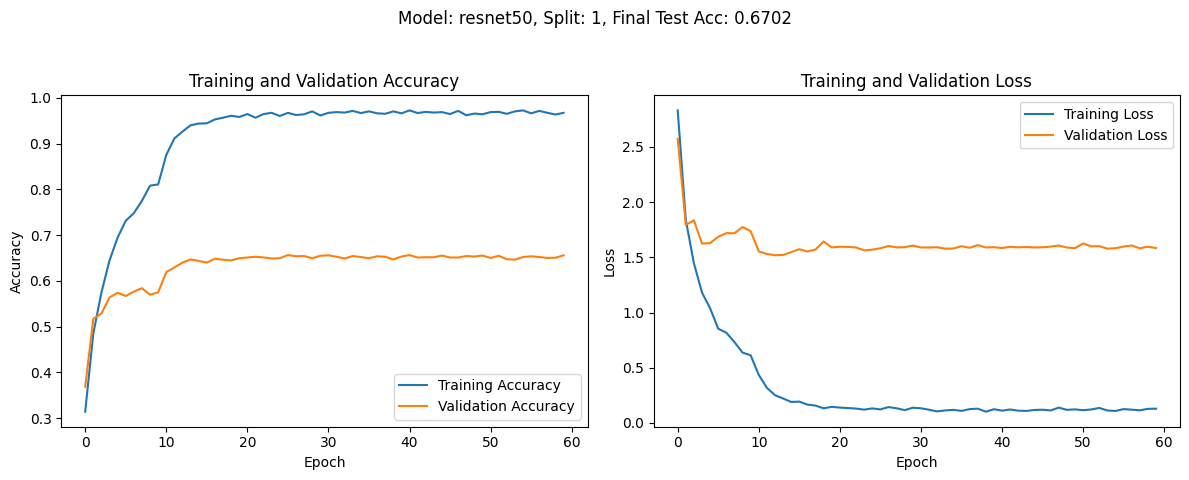

In [ ]:
print(f"Loading pre-trained model: {model_name}")

try:
    if model_name == "resnet50":
        weights = models.ResNet50_Weights.DEFAULT
        model_ft = models.resnet50(weights=weights)
        input_size = weights.transforms().crop_size[0]
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor(), # ToTensor comes before Normalize
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
            'val': transforms.Compose([
                transforms.Resize(weights.transforms().resize_size[0]), # Use recommended resize
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
             'test': transforms.Compose([
                transforms.Resize(weights.transforms().resize_size[0]),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
        }
        print(f"Using recommended transforms for {model_name}: Resize={weights.transforms().resize_size[0]}, Crop={input_size}")

    elif model_name == "resnet101":
        weights = models.ResNet101_Weights.DEFAULT
        model_ft = models.resnet101(weights=weights)
        # Similar transform update needed if using this model
    elif model_name == "vgg19_bn":
        weights = models.VGG19_BN_Weights.DEFAULT
        model_ft = models.vgg19_bn(weights=weights)
        # Similar transform update needed if using this model
    else:
        print(f"Model {model_name} not recognized or implemented. Exiting.")
        exit()

except Exception as e:
    print(f"Error loading model or weights: {e}")
    print("Make sure you have the latest torchvision version.")
    exit()


# Modify the final fully connected layer for DTD (47 classes)
if hasattr(model_ft, 'fc'): # For ResNet
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
elif hasattr(model_ft, 'classifier'): # Common attribute for VGG, EfficientNet, etc.
    # Need specific handling based on model architecture
    if model_name.startswith("vgg"):
         # VGG's classifier is a Sequential module, modify the last layer
        if isinstance(model_ft.classifier, nn.Sequential):
            num_ftrs = model_ft.classifier[-1].in_features
            model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        else:
             print("VGG classifier structure not as expected. Manual adjustment needed.")
             exit()
    elif model_name.startswith("efficientnet"):
         if isinstance(model_ft.classifier, nn.Sequential):
            num_ftrs = model_ft.classifier[-1].in_features
            model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
         else: # Some EfficientNet variants might have a single Linear layer
             num_ftrs = model_ft.classifier.in_features
             model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    # Add handlers for other model types if necessary
    else:
        print(f"Automatic classifier modification for {model_name} not implemented. Manual adjustment needed.")
        exit()
else:
    print("Model structure not recognized for automatic final layer modification.")
    exit()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Switched to AdamW optimizer and added weight decay
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Decay LR by a factor of gamma every step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_lr_size, gamma=step_lr_gamma)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            processed_samples = 0 # Track processed samples accurately

            # Iterate over data.
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                # Skip empty batches potentially caused by collate_fn filtering
                if inputs.nelement() == 0 or labels.nelement() == 0:
                    print(f"Skipping empty batch in phase {phase}, epoch {epoch}")
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)
                current_batch_size = inputs.size(0) # Get actual batch size

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * current_batch_size
                running_corrects += torch.sum(preds == labels.data)
                processed_samples += current_batch_size

                batch_num += 1
                if batch_num % 50 == 0: # Print progress every 50 batches
                     print(f'  [{phase}] Epoch {epoch} Batch {batch_num}/{len(dataloaders[phase])} Loss: {loss.item():.4f}')


            if phase == 'train':
                scheduler.step() # Step the learning rate scheduler

            # Ensure processed_samples is not zero before division
            if processed_samples == 0:
                 print(f"Warning: No samples processed in phase {phase}, epoch {epoch}. Skipping metric calculation.")
                 epoch_loss = 0.0
                 epoch_acc = 0.0
            else:
                epoch_loss = running_loss / processed_samples
                epoch_acc = running_corrects.double() / processed_samples


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item() if isinstance(epoch_acc, torch.Tensor) else epoch_acc) # Use .item() to get Python number
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item() if isinstance(epoch_acc, torch.Tensor) else epoch_acc)

            # Deep copy the model if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model checkpoint
                save_path = f'dtd_{model_name}_best_split{split_num}_acc{best_acc:.4f}.pth'
                torch.save(model.state_dict(), save_path)
                print(f"  Best validation accuracy improved to {best_acc:.4f}. Model saved to {save_path}")


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs}


print("Starting training...")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=num_epochs)


def test_model(model, dataloader):
    model.eval() # Set model to evaluation mode
    running_corrects = 0
    total = 0

    print("\nStarting testing...")
    since = time.time()

    with torch.no_grad(): # No need to track gradients during testing
        for inputs, labels in dataloader:
             # Skip empty batches
            if inputs.nelement() == 0 or labels.nelement() == 0:
                print("Skipping empty batch in testing")
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            current_batch_size = inputs.size(0)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += current_batch_size
            running_corrects += torch.sum(preds == labels.data)

    # Ensure total is not zero before division
    if total == 0:
        print("Warning: No samples processed during testing.")
        accuracy = 0.0
    else:
        accuracy = running_corrects.double() / total

    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy.item() if isinstance(accuracy, torch.Tensor) else accuracy

best_model_path = f'dtd_{model_name}_best_split{split_num}_acc{history["val_acc"][-1]:.4f}.pth'

import glob
list_of_files = glob.glob(f'dtd_{model_name}_best_split{split_num}_acc*.pth')
if list_of_files:
    best_model_path = max(list_of_files, key=os.path.getctime) # Get the latest saved best model
    print(f"Loading best model weights from: {best_model_path}")
    model_ft.load_state_dict(torch.load(best_model_path))
else:
    print("Warning: No saved best model checkpoint found. Testing with the last epoch's weights.")


test_accuracy = test_model(model_ft, dataloaders['test'])


try:
    import matplotlib.pyplot as plt

    epochs_range = range(num_epochs)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Ensure history lists are not empty before plotting
    if history['train_acc'] and history['val_acc']:
        plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    if history['train_loss'] and history['val_loss']:
        plt.plot(epochs_range, history['train_loss'], label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

    plt.suptitle(f'Model: {model_name}, Split: {split_num}, Final Test Acc: {test_accuracy:.4f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    # Save the plot if running in a non-interactive environment
    plot_filename = f'dtd_{model_name}_training_history_split{split_num}.png'
    plt.savefig(plot_filename)
    print(f"\nTraining history plot saved as {plot_filename}")
    # plt.show() # Uncomment if running interactively and want to display the plot

except ImportError:
    print("\nMatplotlib not found. Skipping plot generation.")
    print("Install matplotlib to visualize training history: pip install matplotlib")
except Exception as e:
    print(f"\nError generating plot: {e}")


print("\nFinished.")


Using device: cuda:0
Initializing Datasets and Dataloaders...
Dataset sizes: {'train': 1880, 'val': 1880, 'test': 1880}
Number of classes: 47
Loading pre-trained model: resnet101


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 183MB/s]


Starting training...
Epoch 0/29
----------
  [train] Epoch 0 Batch 50/59 Loss: 2.2692
train Loss: 2.6632 Acc: 0.3346
  [val] Epoch 0 Batch 50/59 Loss: 1.9447
val Loss: 2.0172 Acc: 0.4750
  Best validation accuracy improved to 0.4750. Model saved to dtd_resnet101_best_split1_acc0.4750.pth

Epoch 1/29
----------
  [train] Epoch 1 Batch 50/59 Loss: 2.1103
train Loss: 1.7141 Acc: 0.5186
  [val] Epoch 1 Batch 50/59 Loss: 1.2219
val Loss: 1.7483 Acc: 0.5452
  Best validation accuracy improved to 0.5452. Model saved to dtd_resnet101_best_split1_acc0.5452.pth

Epoch 2/29
----------
  [train] Epoch 2 Batch 50/59 Loss: 1.0885
train Loss: 1.3016 Acc: 0.6255
  [val] Epoch 2 Batch 50/59 Loss: 0.9970
val Loss: 1.6066 Acc: 0.5707
  Best validation accuracy improved to 0.5707. Model saved to dtd_resnet101_best_split1_acc0.5707.pth

Epoch 3/29
----------
  [train] Epoch 3 Batch 50/59 Loss: 0.9850
train Loss: 1.0642 Acc: 0.6894
  [val] Epoch 3 Batch 50/59 Loss: 1.1734
val Loss: 1.6691 Acc: 0.5638

Epoch

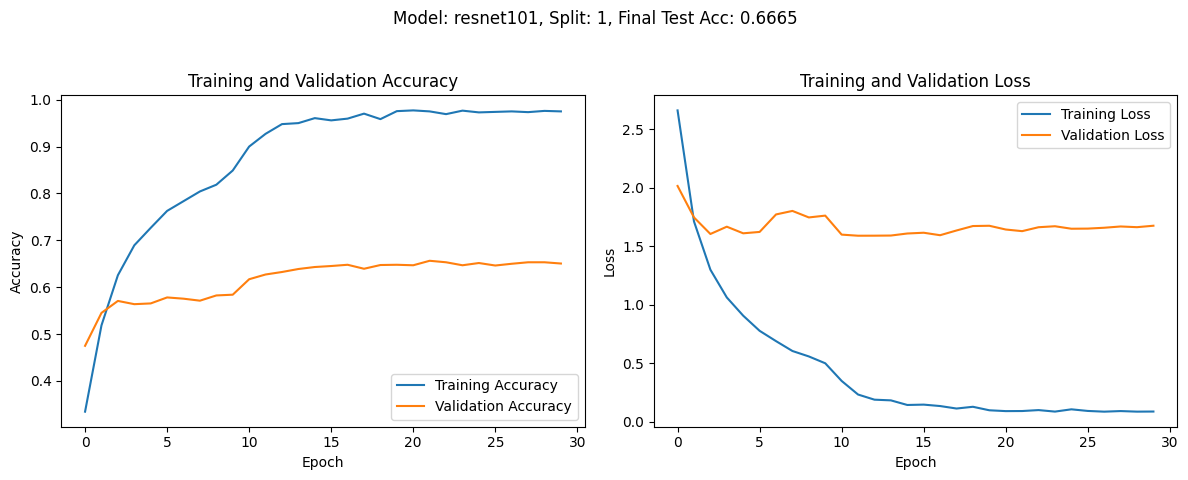

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import time
import os
import copy
import argparse


dataset_base_dir = '/content/drive/MyDrive/dtd'
image_dir = os.path.join(dataset_base_dir, 'images')
labels_dir = os.path.join(dataset_base_dir, 'labels')
split_num = 1

model_name = "resnet101"
num_classes = 47
batch_size = 32
num_epochs = 30
learning_rate = 0.0005
weight_decay = 0.01 # Added weight decay for regularization
step_lr_size = 10 # Adjusted scheduler step size
step_lr_gamma = 0.1

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class DTDDataset(Dataset):
    """Custom Dataset for DTD."""
    def __init__(self, image_dir, label_file, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            label_file (string): Path to the file with image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Read class names and create mapping
        self.class_names = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        # Read the label file (e.g., train1.txt)
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        img_full_path = os.path.join(self.image_dir, line)
                        # Check if the image file actually exists before adding
                        if os.path.exists(img_full_path):
                            self.image_paths.append(img_full_path)
                            # Extract class name from the path
                            class_name = line.split('/')[0]
                            self.labels.append(self.class_to_idx[class_name])
                        else:
                            print(f"Warning: Image path specified in {os.path.basename(label_file)} not found: {img_full_path}")
        except FileNotFoundError:
            print(f"Error: Label file not found at {label_file}")
            raise # Re-raise the exception to stop execution if label file is missing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        try:
            # Open image only if path is valid (already checked in __init__)
            image = Image.open(img_path).convert('RGB') # Ensure image is RGB
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            # Return None pair if image loading fails, handled by collate_fn
            return None, None

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

input_size = 224 # Input size expected by ResNet

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), # Added rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Added color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


print("Initializing Datasets and Dataloaders...")

if not os.path.isdir(dataset_base_dir):
    print(f"Error: Dataset base directory not found at {dataset_base_dir}")
    print("Please download the DTD dataset and place it in the correct directory,")
    print("or update the 'dataset_base_dir' variable in the script.")
    exit() # Exit if dataset is not found

train_label_file = os.path.join(labels_dir, f'train{split_num}.txt')
val_label_file = os.path.join(labels_dir, f'val{split_num}.txt')
test_label_file = os.path.join(labels_dir, f'test{split_num}.txt')

# Ensure label files exist before creating datasets
if not all(os.path.exists(f) for f in [train_label_file, val_label_file, test_label_file]):
     print(f"Error: Label files (train{split_num}.txt, val{split_num}.txt, test{split_num}.txt) not found in {labels_dir}")
     exit()

try:
    image_datasets = {
        'train': DTDDataset(image_dir, train_label_file, data_transforms['train']),
        'val': DTDDataset(image_dir, val_label_file, data_transforms['val']),
        'test': DTDDataset(image_dir, test_label_file, data_transforms['test'])
    }

    # Handle potential None values from failed image loading in __getitem__
    def collate_fn(batch):
        # Filter out samples where image loading failed (returned None)
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch:
            # Return empty tensors if the whole batch failed
            return torch.Tensor(), torch.Tensor()
        # Use default collate function for valid samples
        return torch.utils.data.dataloader.default_collate(batch)

    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=2, collate_fn=collate_fn, pin_memory=True) # Added pin_memory
        for x in ['train', 'val', 'test']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].class_names # Get class names from the dataset object

    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Number of classes: {len(class_names)}")

except Exception as e:
    print(f"Error creating datasets or dataloaders: {e}")
    print("Please check the dataset path and structure.")
    exit()

print(f"Loading pre-trained model: {model_name}")

try:
    if model_name == "resnet50":
        weights = models.ResNet50_Weights.DEFAULT # Use DEFAULT for latest recommended weights
        model_ft = models.resnet50(weights=weights)
        # Update transforms to match the weights' recommendation
        input_size = weights.transforms().crop_size[0] # Get input size from weights
        # Re-define transforms based on model's recommended preprocessing
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor(), # ToTensor comes before Normalize
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
            'val': transforms.Compose([
                transforms.Resize(weights.transforms().resize_size[0]), # Use recommended resize
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
             'test': transforms.Compose([
                transforms.Resize(weights.transforms().resize_size[0]),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
        }
        print(f"Using recommended transforms for {model_name}: Resize={weights.transforms().resize_size[0]}, Crop={input_size}")

    elif model_name == "resnet101":
        weights = models.ResNet101_Weights.DEFAULT
        model_ft = models.resnet101(weights=weights)
        # Similar transform update needed if using this model
    elif model_name == "vgg19_bn":
        weights = models.VGG19_BN_Weights.DEFAULT
        model_ft = models.vgg19_bn(weights=weights)
    else:
        print(f"Model {model_name} not recognized or implemented. Exiting.")
        exit()

except Exception as e:
    print(f"Error loading model or weights: {e}")
    print("Make sure you have the latest torchvision version.")
    exit()


# Modify the final fully connected layer for DTD (47 classes)
if hasattr(model_ft, 'fc'): # For ResNet
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
elif hasattr(model_ft, 'classifier'):
    if model_name.startswith("vgg"):
        if isinstance(model_ft.classifier, nn.Sequential):
            num_ftrs = model_ft.classifier[-1].in_features
            model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        else:
             print("VGG classifier structure not as expected. Manual adjustment needed.")
             exit()
    elif model_name.startswith("efficientnet"):
         if isinstance(model_ft.classifier, nn.Sequential):
            num_ftrs = model_ft.classifier[-1].in_features
            model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
         else:
             num_ftrs = model_ft.classifier.in_features
             model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    # Add handlers for other model types if necessary
    else:
        print(f"Automatic classifier modification for {model_name} not implemented. Manual adjustment needed.")
        exit()
else:
    print("Model structure not recognized for automatic final layer modification.")
    exit()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Switched to AdamW optimizer and added weight decay
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Decay LR by a factor of gamma every step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_lr_size, gamma=step_lr_gamma)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            processed_samples = 0 # Track processed samples accurately

            # Iterate over data.
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                # Skip empty batches potentially caused by collate_fn filtering
                if inputs.nelement() == 0 or labels.nelement() == 0:
                    print(f"Skipping empty batch in phase {phase}, epoch {epoch}")
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)
                current_batch_size = inputs.size(0) # Get actual batch size

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * current_batch_size
                running_corrects += torch.sum(preds == labels.data)
                processed_samples += current_batch_size

                batch_num += 1
                if batch_num % 50 == 0: # Print progress every 50 batches
                     print(f'  [{phase}] Epoch {epoch} Batch {batch_num}/{len(dataloaders[phase])} Loss: {loss.item():.4f}')


            if phase == 'train':
                scheduler.step() # Step the learning rate scheduler

            # Ensure processed_samples is not zero before division
            if processed_samples == 0:
                 print(f"Warning: No samples processed in phase {phase}, epoch {epoch}. Skipping metric calculation.")
                 epoch_loss = 0.0
                 epoch_acc = 0.0
            else:
                epoch_loss = running_loss / processed_samples
                epoch_acc = running_corrects.double() / processed_samples


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item() if isinstance(epoch_acc, torch.Tensor) else epoch_acc) # Use .item() to get Python number
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item() if isinstance(epoch_acc, torch.Tensor) else epoch_acc)

            # Deep copy the model if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model checkpoint
                save_path = f'dtd_{model_name}_best_split{split_num}_acc{best_acc:.4f}.pth'
                torch.save(model.state_dict(), save_path)
                print(f"  Best validation accuracy improved to {best_acc:.4f}. Model saved to {save_path}")


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs}

print("Starting training...")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=num_epochs)

def test_model(model, dataloader):
    model.eval() # Set model to evaluation mode
    running_corrects = 0
    total = 0

    print("\nStarting testing...")
    since = time.time()

    with torch.no_grad(): # No need to track gradients during testing
        for inputs, labels in dataloader:
             # Skip empty batches
            if inputs.nelement() == 0 or labels.nelement() == 0:
                print("Skipping empty batch in testing")
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            current_batch_size = inputs.size(0)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += current_batch_size
            running_corrects += torch.sum(preds == labels.data)

    # Ensure total is not zero before division
    if total == 0:
        print("Warning: No samples processed during testing.")
        accuracy = 0.0
    else:
        accuracy = running_corrects.double() / total

    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy.item() if isinstance(accuracy, torch.Tensor) else accuracy

best_model_path = f'dtd_{model_name}_best_split{split_num}_acc{history["val_acc"][-1]:.4f}.pth' # Construct path based on final val acc (or find the actual best saved one)
import glob
list_of_files = glob.glob(f'dtd_{model_name}_best_split{split_num}_acc*.pth')
if list_of_files:
    best_model_path = max(list_of_files, key=os.path.getctime) # Get the latest saved best model
    print(f"Loading best model weights from: {best_model_path}")
    model_ft.load_state_dict(torch.load(best_model_path))
else:
    print("Warning: No saved best model checkpoint found. Testing with the last epoch's weights.")


test_accuracy = test_model(model_ft, dataloaders['test'])

try:
    import matplotlib.pyplot as plt

    epochs_range = range(num_epochs)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Ensure history lists are not empty before plotting
    if history['train_acc'] and history['val_acc']:
        plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    if history['train_loss'] and history['val_loss']:
        plt.plot(epochs_range, history['train_loss'], label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

    plt.suptitle(f'Model: {model_name}, Split: {split_num}, Final Test Acc: {test_accuracy:.4f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    # Save the plot if running in a non-interactive environment
    plot_filename = f'dtd_{model_name}_training_history_split{split_num}.png'
    plt.savefig(plot_filename)
    print(f"\nTraining history plot saved as {plot_filename}")
    # plt.show() # Uncomment if running interactively and want to display the plot

except ImportError:
    print("\nMatplotlib not found. Skipping plot generation.")
    print("Install matplotlib to visualize training history: pip install matplotlib")
except Exception as e:
    print(f"\nError generating plot: {e}")


print("\nFinished.")


Using device: cuda:0
Initializing Datasets and Dataloaders...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Dataset sizes: {'train': 1880, 'val': 1880, 'test': 1880}
Number of classes: 47
Loading pre-trained model: efficientnet_b0


100%|██████████| 20.5M/20.5M [00:00<00:00, 77.8MB/s]


Starting training...
Epoch 0/29
----------
  [train] Epoch 0 Batch 50/59 Loss: 2.3261
train Loss: 2.9921 Acc: 0.2718
  [val] Epoch 0 Batch 50/59 Loss: 1.0006
val Loss: 2.0196 Acc: 0.4569
  Best validation accuracy improved to 0.4569. Model saved to dtd_efficientnet_b0_best_split1_acc0.4569.pth

Epoch 1/29
----------
  [train] Epoch 1 Batch 50/59 Loss: 1.6408
train Loss: 1.7227 Acc: 0.5250
  [val] Epoch 1 Batch 50/59 Loss: 1.0658
val Loss: 1.6220 Acc: 0.5606
  Best validation accuracy improved to 0.5606. Model saved to dtd_efficientnet_b0_best_split1_acc0.5606.pth

Epoch 2/29
----------
  [train] Epoch 2 Batch 50/59 Loss: 1.1442
train Loss: 1.3368 Acc: 0.6074
  [val] Epoch 2 Batch 50/59 Loss: 0.8624
val Loss: 1.5348 Acc: 0.5819
  Best validation accuracy improved to 0.5819. Model saved to dtd_efficientnet_b0_best_split1_acc0.5819.pth

Epoch 3/29
----------
  [train] Epoch 3 Batch 50/59 Loss: 1.2357
train Loss: 1.0805 Acc: 0.6755
  [val] Epoch 3 Batch 50/59 Loss: 1.1845
val Loss: 1.4956 

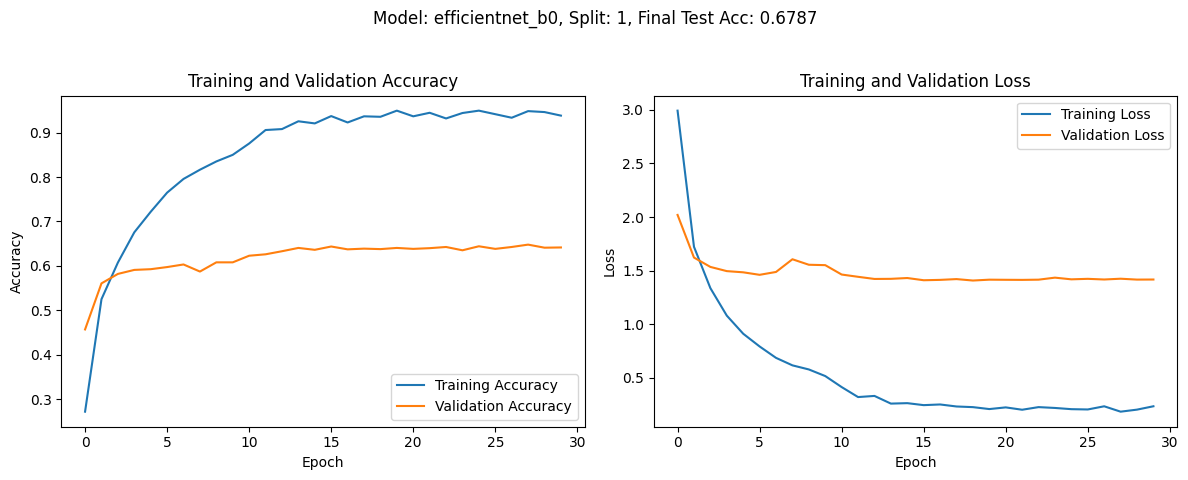

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import time
import os
import copy
import argparse

dataset_base_dir = '/content/drive/MyDrive/dtd'
image_dir = os.path.join(dataset_base_dir, 'images')
labels_dir = os.path.join(dataset_base_dir, 'labels')
split_num = 1

# Training Hyperparameters - ADJUSTED
model_name = "efficientnet_b0"
num_classes = 47
batch_size = 32
num_epochs = 30 # Increased epochs
learning_rate = 0.0005 # Slightly decreased learning rate
weight_decay = 0.01 # Added weight decay for regularization
step_lr_size = 10 # Adjusted scheduler step size
step_lr_gamma = 0.1

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class DTDDataset(Dataset):
    """Custom Dataset for DTD."""
    def __init__(self, image_dir, label_file, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            label_file (string): Path to the file with image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Read class names and create mapping
        self.class_names = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        # Read the label file (e.g., train1.txt)
        try:
            with open(label_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        img_full_path = os.path.join(self.image_dir, line)
                        # Check if the image file actually exists before adding
                        if os.path.exists(img_full_path):
                            self.image_paths.append(img_full_path)
                            # Extract class name from the path
                            class_name = line.split('/')[0]
                            self.labels.append(self.class_to_idx[class_name])
                        else:
                            print(f"Warning: Image path specified in {os.path.basename(label_file)} not found: {img_full_path}")
        except FileNotFoundError:
            print(f"Error: Label file not found at {label_file}")
            raise # Re-raise the exception to stop execution if label file is missing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        try:
            # Open image only if path is valid (already checked in __init__)
            image = Image.open(img_path).convert('RGB') # Ensure image is RGB
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            # Return None pair if image loading fails, handled by collate_fn
            return None, None

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

input_size = 224 # Input size expected by ResNet

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), # Added rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Added color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Create Datasets and Dataloaders ---

print("Initializing Datasets and Dataloaders...")

# Check if dataset directories exist
if not os.path.isdir(dataset_base_dir):
    print(f"Error: Dataset base directory not found at {dataset_base_dir}")
    print("Please download the DTD dataset and place it in the correct directory,")
    print("or update the 'dataset_base_dir' variable in the script.")
    exit() # Exit if dataset is not found

train_label_file = os.path.join(labels_dir, f'train{split_num}.txt')
val_label_file = os.path.join(labels_dir, f'val{split_num}.txt')
test_label_file = os.path.join(labels_dir, f'test{split_num}.txt')

# Ensure label files exist before creating datasets
if not all(os.path.exists(f) for f in [train_label_file, val_label_file, test_label_file]):
     print(f"Error: Label files (train{split_num}.txt, val{split_num}.txt, test{split_num}.txt) not found in {labels_dir}")
     exit()

try:
    image_datasets = {
        'train': DTDDataset(image_dir, train_label_file, data_transforms['train']),
        'val': DTDDataset(image_dir, val_label_file, data_transforms['val']),
        'test': DTDDataset(image_dir, test_label_file, data_transforms['test'])
    }

    # Handle potential None values from failed image loading in __getitem__
    def collate_fn(batch):
        # Filter out samples where image loading failed (returned None)
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch:
            # Return empty tensors if the whole batch failed
            return torch.Tensor(), torch.Tensor()
        # Use default collate function for valid samples
        return torch.utils.data.dataloader.default_collate(batch)

    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=2, collate_fn=collate_fn, pin_memory=True) # Added pin_memory
        for x in ['train', 'val', 'test']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].class_names # Get class names from the dataset object

    print(f"Dataset sizes: {dataset_sizes}")
    print(f"Number of classes: {len(class_names)}")

except Exception as e:
    print(f"Error creating datasets or dataloaders: {e}")
    print("Please check the dataset path and structure.")
    exit()

print(f"Loading pre-trained model: {model_name}")

try:
    if model_name == "resnet50":
        weights = models.ResNet50_Weights.DEFAULT # Use DEFAULT for latest recommended weights
        model_ft = models.resnet50(weights=weights)
        # Update transforms to match the weights' recommendation
        input_size = weights.transforms().crop_size[0] # Get input size from weights
        # Re-define transforms based on model's recommended preprocessing
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor(), # ToTensor comes before Normalize
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
            'val': transforms.Compose([
                transforms.Resize(weights.transforms().resize_size[0]), # Use recommended resize
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
             'test': transforms.Compose([
                transforms.Resize(weights.transforms().resize_size[0]),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
            ]),
        }
        print(f"Using recommended transforms for {model_name}: Resize={weights.transforms().resize_size[0]}, Crop={input_size}")

    elif model_name == "resnet101":
        weights = models.ResNet101_Weights.DEFAULT
        model_ft = models.resnet101(weights=weights)
    elif model_name == "vgg19_bn":
        weights = models.VGG19_BN_Weights.DEFAULT
        model_ft = models.vgg19_bn(weights=weights)
    elif model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.DEFAULT
        model_ft = models.efficientnet_b0(weights=weights)
    else:
        print(f"Model {model_name} not recognized or implemented. Exiting.")
        exit()

except Exception as e:
    print(f"Error loading model or weights: {e}")
    print("Make sure you have the latest torchvision version.")
    exit()


# Modify the final fully connected layer for DTD (47 classes)
if hasattr(model_ft, 'fc'):
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
elif hasattr(model_ft, 'classifier'):
    # Need specific handling based on model architecture
    if model_name.startswith("vgg"):
        if isinstance(model_ft.classifier, nn.Sequential):
            num_ftrs = model_ft.classifier[-1].in_features
            model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        else:
             print("VGG classifier structure not as expected. Manual adjustment needed.")
             exit()
    elif model_name.startswith("efficientnet"):
         if isinstance(model_ft.classifier, nn.Sequential):
            num_ftrs = model_ft.classifier[-1].in_features
            model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
         else:
             num_ftrs = model_ft.classifier.in_features
             model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    # Add handlers for other model types if necessary
    else:
        print(f"Automatic classifier modification for {model_name} not implemented. Manual adjustment needed.")
        exit()
else:
    print("Model structure not recognized for automatic final layer modification.")
    exit()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Switched to AdamW optimizer and added weight decay
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Decay LR by a factor of gamma every step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_lr_size, gamma=step_lr_gamma)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            processed_samples = 0 # Track processed samples accurately

            # Iterate over data.
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                # Skip empty batches potentially caused by collate_fn filtering
                if inputs.nelement() == 0 or labels.nelement() == 0:
                    print(f"Skipping empty batch in phase {phase}, epoch {epoch}")
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)
                current_batch_size = inputs.size(0) # Get actual batch size

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * current_batch_size
                running_corrects += torch.sum(preds == labels.data)
                processed_samples += current_batch_size

                batch_num += 1
                if batch_num % 50 == 0: # Print progress every 50 batches
                     print(f'  [{phase}] Epoch {epoch} Batch {batch_num}/{len(dataloaders[phase])} Loss: {loss.item():.4f}')


            if phase == 'train':
                scheduler.step() # Step the learning rate scheduler

            # Ensure processed_samples is not zero before division
            if processed_samples == 0:
                 print(f"Warning: No samples processed in phase {phase}, epoch {epoch}. Skipping metric calculation.")
                 epoch_loss = 0.0
                 epoch_acc = 0.0
            else:
                epoch_loss = running_loss / processed_samples
                epoch_acc = running_corrects.double() / processed_samples


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item() if isinstance(epoch_acc, torch.Tensor) else epoch_acc) # Use .item() to get Python number
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item() if isinstance(epoch_acc, torch.Tensor) else epoch_acc)

            # Deep copy the model if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model checkpoint
                save_path = f'dtd_{model_name}_best_split{split_num}_acc{best_acc:.4f}.pth'
                torch.save(model.state_dict(), save_path)
                print(f"  Best validation accuracy improved to {best_acc:.4f}. Model saved to {save_path}")


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs}

print("Starting training...")
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=num_epochs)

def test_model(model, dataloader):
    model.eval() # Set model to evaluation mode
    running_corrects = 0
    total = 0

    print("\nStarting testing...")
    since = time.time()

    with torch.no_grad(): # No need to track gradients during testing
        for inputs, labels in dataloader:
             # Skip empty batches
            if inputs.nelement() == 0 or labels.nelement() == 0:
                print("Skipping empty batch in testing")
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)
            current_batch_size = inputs.size(0)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += current_batch_size
            running_corrects += torch.sum(preds == labels.data)

    # Ensure total is not zero before division
    if total == 0:
        print("Warning: No samples processed during testing.")
        accuracy = 0.0
    else:
        accuracy = running_corrects.double() / total

    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy.item() if isinstance(accuracy, torch.Tensor) else accuracy

best_model_path = f'dtd_{model_name}_best_split{split_num}_acc{history["val_acc"][-1]:.4f}.pth' # Construct path based on final val acc (or find the actual best saved one)
import glob
list_of_files = glob.glob(f'dtd_{model_name}_best_split{split_num}_acc*.pth')
if list_of_files:
    best_model_path = max(list_of_files, key=os.path.getctime) # Get the latest saved best model
    print(f"Loading best model weights from: {best_model_path}")
    model_ft.load_state_dict(torch.load(best_model_path))
else:
    print("Warning: No saved best model checkpoint found. Testing with the last epoch's weights.")


test_accuracy = test_model(model_ft, dataloaders['test'])

try:
    import matplotlib.pyplot as plt

    epochs_range = range(num_epochs)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Ensure history lists are not empty before plotting
    if history['train_acc'] and history['val_acc']:
        plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    if history['train_loss'] and history['val_loss']:
        plt.plot(epochs_range, history['train_loss'], label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

    plt.suptitle(f'Model: {model_name}, Split: {split_num}, Final Test Acc: {test_accuracy:.4f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plot_filename = f'dtd_{model_name}_training_history_split{split_num}.png'
    plt.savefig(plot_filename)
    print(f"\nTraining history plot saved as {plot_filename}")

except ImportError:
    print("\nMatplotlib not found. Skipping plot generation.")
    print("Install matplotlib to visualize training history: pip install matplotlib")
except Exception as e:
    print(f"\nError generating plot: {e}")

print("\nFinished.")
